In [ ]:
!pip install uncertainty_toolbox
!pip install pytorch_lightning
# Install library for learning deep UQ baselines.
#!git clone https://github.com/uncertainty-toolbox/simple-uq
#!pip install -e ./simple-uq
#%mv simple-uq/simple_uq .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 12.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [ ]:
#use mount instead if faster?
import io
import pandas as pd
import torch

# Imports
import random
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Import Uncertainty Toolbox
import uncertainty_toolbox as uct

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

#MLP

In [ ]:
"""
A basic multi-layer perceptron implementation.
"""
from typing import Callable, Optional, Sequence

import torch
import torch.nn.functional as F


class MLP(torch.nn.Module):
    """MLP Network."""

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_sizes: Sequence[int],
        hidden_activation: Callable[[torch.tensor], torch.tensor] = F.relu,
        out_activation: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        """Constructor.

        Args:
            input_dim: Dimension of input data.
            output_dim: Dimesnion of data outputted.
            hidden_sizes: List of sizes for the hidden layers.
            hidden_activation: Hidden activation function.
            out_activation: The activation function to apply on output.
        """
        super().__init__()
        if len(hidden_sizes) == 0:
            self._add_linear_layer(input_dim, output_dim, 0)
            self.n_layers = 1
        else:
            self._add_linear_layer(input_dim, hidden_sizes[0], 0)
            for hidx in range(len(hidden_sizes) - 1):
                self._add_linear_layer(
                    hidden_sizes[hidx], hidden_sizes[hidx + 1], hidx + 1
                )
            self._add_linear_layer(hidden_sizes[-1], output_dim, len(hidden_sizes))
            self.n_layers = len(hidden_sizes) + 1
        self.hidden_activation = hidden_activation
        self.out_activation = out_activation

    def forward(
        self,
        net_in: torch.tensor,
    ) -> torch.tensor:
        """Forward pass through network.

        Args:
            net_in: The input to the network.

        Returns:
            The output of the network.
        """
        curr = net_in
        for layer_num in range(self.n_layers - 1):
            curr = getattr(self, "linear_%d" % layer_num)(curr)
            curr = self.hidden_activation(curr)
        curr = getattr(self, "linear_%d" % (self.n_layers - 1))(curr)
        if self.out_activation is not None:
            return self.out_activation(curr)
        return curr

    def _add_linear_layer(
        self,
        lin_in: int,
        lin_out: int,
        layer_num: int,
    ) -> None:
        """Add a linear layer to the network.

        Args:
            lin_in: Input dimension to the layer.
            lin_out: Output dimension of the layer.
            layer_num: The number of the layer being added.
        """
        layer = torch.nn.Linear(lin_in, lin_out)
        self.add_module("linear_%d" % layer_num, layer)

#PNN

In [ ]:
""" Basic implementation of a Probabilistic Neural Network (PNN). This is a
neural network that outputs the mean and variance of a standard normal.
"""
from typing import Callable, Sequence, Tuple

import numpy as np
from pytorch_lightning import LightningModule
import torch
import torch.nn.functional as F

class PNN(LightningModule):
    """Probabilistic neural network (PNN) outputting Gaussian distribution.

    This model is implemented as a two headed neural network. The two heads
    output the mean and logvariance of a multi-variate normal.
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        encoder_hidden_sizes: Sequence[int],
        encoder_output_dim: int,
        mean_hidden_sizes: Sequence[int],
        logvar_hidden_sizes: Sequence[int],
        hidden_activation: Callable[[torch.tensor], torch.tensor] = F.relu,
        learning_rate: float = 1e-3,
    ):
        """Constructor.

        Args:
            input_dim: Dimension of input data.
            output_dim: Dimesnion of data outputted.
            hidden_activation: Hidden activation function.
            encoder_hidden_sizes: List of the hidden sizes for the encoder.
            encoder_output_dim: Dimension of the data outputted by the encoder.
            mean_hidden_sizes: List of hidden sizes for mean head.
            logvar_hidden_sizes: List of hidden sizes for logvar head.
        """
        super().__init__()
        self._learning_rate = learning_rate
        self.encoder = MLP(
            input_dim=input_dim,
            output_dim=encoder_output_dim,
            hidden_sizes=encoder_hidden_sizes,
            hidden_activation=hidden_activation,
        )
        self.mean_head = MLP(
            input_dim=encoder_output_dim,
            output_dim=output_dim,
            hidden_sizes=mean_hidden_sizes,
            hidden_activation=hidden_activation,
        )
        self.logvar_head = MLP(
            input_dim=encoder_output_dim,
            output_dim=output_dim,
            hidden_sizes=logvar_hidden_sizes,
            hidden_activation=hidden_activation,
        )

    def get_mean_and_standard_deviation(
        self,
        x_data: np.ndarray,
        device: str = "cpu",
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Get the mean and standard deviation prediction.

        Args:
            x_data: The data in numpy ndarray form.
            device: The device to use. Should be the same as the device
                the model is currently on.

        Returns:
            Mean and standard deviation as ndarrays
        """
        with torch.no_grad():
            mean, logvar = self.forward(torch.tensor(x_data, device=device))
        mean = mean.numpy()
        std = (logvar / 2).exp().numpy()
        return mean, std

    def forward(
        self,
        x_data: torch.tensor,
    ) -> Tuple[torch.tensor, torch.tensor]:
        """Get the mean and standard deviation prediction.

        Args:
            x_data: The data in tensor form.

        Returns:
            Mean and log variance as tensors.
        """
        latent = self.encoder(x_data)
        return self.mean_head(latent), self.logvar_head(latent)

    def training_step(
        self,
        batch: Tuple[torch.tensor, torch.tensor],
        batch_idx: int,
    ) -> torch.tensor:
        """Do a training step.

        Args:
            batch: The x and y data to train on.
            batch_idx: Index of he batch.

        Returns:
            The loss.
        """
        x_data, y_data = batch
        mean, logvar = self.forward(x_data)
        loss = torch.mean(self.compute_nll(mean, logvar, y_data))
        self.log("train_loss", loss)
        return loss

    def validation_step(
        self,
        batch: Tuple[torch.tensor, torch.tensor],
        batch_idx: int,
    ) -> None:
        """Do a validation step.

        Args:
            batch: The x and y data to train on.
            batch_idx: Index of he batch.
        """
        x_data, y_data = batch
        mean, logvar = self.forward(x_data)
        loss = torch.mean(self.compute_nll(mean, logvar, y_data))
        self.log("validation_loss", loss)

    def test_step(
        self,
        batch: Tuple[torch.tensor, torch.tensor],
        batch_idx: int,
    ) -> None:
        """Do a validation step.

        Args:
            batch: The x and y data to train on.
            batch_idx: Index of he batch.
        """
        x_data, y_data = batch
        mean, logvar = self.forward(x_data)
        loss = torch.mean(self.compute_nll(mean, logvar, y_data))
        self.log("test_loss", loss)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """Configure the optimizer.

        Returns:
            Optimizer
        """
        return torch.optim.Adam(self.parameters(), lr=self._learning_rate)

    def compute_nll(
        self,
        mean: torch.tensor,
        logvar: torch.tensor,
        labels: torch.tensor,
    ) -> torch.tensor:
        """Compute the loss as negative log likelihood.

        Args:
            mean: The mean prediction for labels.
            logvar: The logvariance prediction for labels.
            labels: The observed labels of the data.

        Returns:
            The negative log likelihood of each point.
        """
        sqdiffs = (mean - labels) ** 2
        return torch.exp(-logvar) * sqdiffs + logvar

#Load HARV data

In [ ]:
from google.colab import files
!rm *.xlsx
uploaded = files.upload()

rm: cannot remove '*.xlsx': No such file or directory


Saving Cbasil_PHB_1G.xlsx to Cbasil_PHB_1G.xlsx
Saving Cbasil_PHB_LSMMG.xlsx to Cbasil_PHB_LSMMG.xlsx
Saving Ecoli_BC_1G.xlsx to Ecoli_BC_1G.xlsx
Saving Ecoli_BC_LSMMG.xlsx to Ecoli_BC_LSMMG.xlsx
Saving Ecoli_EYFP_1G.xlsx to Ecoli_EYFP_1G.xlsx
Saving Ecoli_EYFP_LSMMG.xlsx to Ecoli_EYFP_LSMMG.xlsx
Saving Ppas_BC_1G.xlsx to Ppas_BC_1G.xlsx
Saving Ppas_BC_LSMMG.xlsx to Ppas_BC_LSMMG.xlsx
Saving Ppas_BC_LUNAR.xlsx to Ppas_BC_LUNAR.xlsx
Saving Ppas_BC_MARTIAN.xlsx to Ppas_BC_MARTIAN.xlsx
Saving Ppas_Wild_1G.xlsx to Ppas_Wild_1G.xlsx
Saving Ppas_Wild_LSMMG.xlsx to Ppas_Wild_LSMMG.xlsx
Saving Ppas_Wild_LUNAR.xlsx to Ppas_Wild_LUNAR.xlsx
Saving Ppas_Wild_MARTIAN.xlsx to Ppas_Wild_MARTIAN.xlsx
Saving Pput_Wild_1G.xlsx to Pput_Wild_1G.xlsx
Saving Pput_Wild_LSMMG.xlsx to Pput_Wild_LSMMG.xlsx
Saving Scere_BC_1G.xlsx to Scere_BC_1G.xlsx
Saving Scere_BC_LSMMG.xlsx to Scere_BC_LSMMG.xlsx
Saving Scere_BC_LUNAR.xlsx to Scere_BC_LUNAR.xlsx
Saving Scere_BC_MARTIAN.xlsx to Scere_BC_MARTIAN.xlsx
Saving Sce

In [ ]:
organism_list = []
substance_list = []
gravity_list = []
obj_list = []

class Preprocess:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_list, self.organism)
    self.update_list(substance_list, self.substance)
    self.update_list(gravity_list, self.gravity)

  def update_list(self, item_list, item):
    item_list.append(item)

In [ ]:
for file_name in uploaded.keys():
  obj = Preprocess(file_name)
  obj_list.append(obj)

In [ ]:
from sklearn.preprocessing import LabelEncoder

organism_encode = LabelEncoder()
substance_encode = LabelEncoder()
gravity_encode = LabelEncoder()

organism_label = organism_encode.fit_transform(organism_list)
substance_label = substance_encode.fit_transform(substance_list)
gravity_label = gravity_encode.fit_transform(gravity_list)

In [ ]:
import numpy as np

data_list = []

class Data:
  def __init__(self,file_name, organism, substance, gravity):
    self.file_name = file_name
    self.organism = organism
    self.substance = substance
    self.gravity = gravity

    self.titer_time, self.titer_val = self.assign_data()
    self.titer_input_np = []
    self.titer_val_np = []

    if len(self.titer_time) != 0:
      self.titer_input_np = self.create_inputs(self.titer_time, self.titer_val)
    if len(self.titer_val) != 0:
      self.titer_val_np = self.titer_val.reshape(-1, 1)

  def assign_data(self):
    titer_time = []
    titer_val = []

    if substance_encode.inverse_transform([self.substance])[0] != "Wild":
      titer_df = pd.read_excel(self.file_name, sheet_name = 1).iloc[1:]
      titer_time = titer_df.iloc[:,:1].to_numpy()
      titer_df_transpose = titer_df.iloc[:,1:].T
      titer_df_transpose.fillna(titer_df_transpose.mean(), inplace=True)
      titer_val = titer_df_transpose.T.to_numpy()

    return titer_time, titer_val

  def create_inputs(self, input, output):
    """
    Returns inputs in order of organism, substance, gravity, and time
    """
    input_length = len(input)
    output_length = len(output[0])

    input_stacked = np.tile(input, output_length).reshape(-1, 1)

    categorical_inputs = [self.organism, self.substance, self.gravity]
    categorical_inputs_stacked = np.tile(categorical_inputs, input_length * output_length).reshape(-1, len(categorical_inputs))

    return np.hstack((categorical_inputs_stacked, input_stacked)).astype(float)

In [ ]:
for i, obj in enumerate(obj_list):
  data_obj = Data(obj.file_name, organism_label[i], substance_label[i], gravity_label[i])
  data_list.append(data_obj)
  #print(obj.file_name)

In [ ]:
for obj in obj_list:
  print(obj.file_name)

Cbasil_PHB_1G.xlsx
Cbasil_PHB_LSMMG.xlsx
Ecoli_BC_1G.xlsx
Ecoli_BC_LSMMG.xlsx
Ecoli_EYFP_1G.xlsx
Ecoli_EYFP_LSMMG.xlsx
Ppas_BC_1G.xlsx
Ppas_BC_LSMMG.xlsx
Ppas_BC_LUNAR.xlsx
Ppas_BC_MARTIAN.xlsx
Ppas_Wild_1G.xlsx
Ppas_Wild_LSMMG.xlsx
Ppas_Wild_LUNAR.xlsx
Ppas_Wild_MARTIAN.xlsx
Pput_Wild_1G.xlsx
Pput_Wild_LSMMG.xlsx
Scere_BC_1G.xlsx
Scere_BC_LSMMG.xlsx
Scere_BC_LUNAR.xlsx
Scere_BC_MARTIAN.xlsx
Scere_Wild_1G.xlsx
Scere_Wild_LSMMG.xlsx
Scere_Wild_LUNAR.xlsx
Scere_Wild_MARTIAN.xlsx
Vnat_Wild_1G.xlsx
Vnat_Wild_LSMMG.xlsx
Ylipo_BC_1G.xlsx
Ylipo_BC_LSMMG.xlsx
Ylipo_BC_LUNAR.xlsx
Ylipo_BC_MARTIAN.xlsx
Ylipo_Wild_1G.xlsx
Ylipo_Wild_LSMMG.xlsx
Ylipo_Wild_LUNAR.xlsx
Ylipo_Wild_MARTIAN.xlsx


In [ ]:
#aggregate inputs and outputs
#growth_input = data_list[0].growth_input_np
titer_input = data_list[0].titer_input_np
#growth_output = data_list[0].growth_val_np
titer_output = data_list[0].titer_val_np

for i in range(1, len(data_list)):
  #growth_input = np.vstack((growth_input, data_list[i].growth_input_np))
  #growth_output = np.vstack((growth_output, data_list[i].growth_val_np))
  if len(data_list[i].titer_input_np) > 0:
    titer_input = np.vstack((titer_input, data_list[i].titer_input_np))
    titer_output = np.vstack((titer_output, data_list[i].titer_val_np))

In [ ]:
#standardize time
titer_time_input_mean = np.mean(titer_input[:, 3])
titer_time_input_std_dev = np.std(titer_input[:, 3])
titer_input[:,3] = (titer_input[:, 3] - titer_time_input_mean)/titer_time_input_std_dev
titer_output = np.log(titer_output + 0.1)

In [ ]:
#train test split
from sklearn.model_selection import train_test_split

#80% train, 10% validation, 10% test
#growth_input_train, growth_input_test_val, growth_output_train, growth_output_test_val = train_test_split(growth_input, growth_output, test_size = 0.2, random_state = 42)
#growth_input_val, growth_input_test, growth_output_val, growth_output_test = train_test_split(growth_input_test_val, growth_output_test_val, test_size = 0.5, random_state = 42)

titer_input_train, titer_input_test_val, titer_output_train, titer_output_test_val = train_test_split(titer_input, titer_output, test_size = 0.2, random_state = 42)
titer_input_val, titer_input_test, titer_output_val, titer_output_test = train_test_split(titer_input_test_val, titer_output_test_val, test_size = 0.5, random_state = 42)

In [ ]:
titer_input_train_tensor = torch.tensor(titer_input_train, device=device)
titer_input_test_tensor = torch.tensor(titer_input_test,device=device)
titer_output_train_tensor = torch.tensor(titer_output_train,device=device)
titer_output_test_tensor = torch.tensor(titer_output_test,device=device)
titer_input_val_tensor = torch.tensor(titer_input_val, device=device)
titer_output_val_tensor = torch.tensor(titer_output_val, device=device)

#Load original PNN

In [ ]:
dimension = 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from datetime import datetime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""Make the PNN model."""
pnn = PNN(
    input_dim=dimension,
    output_dim=1,
    encoder_hidden_sizes=[50, 50, 50, 50, 50],
    encoder_output_dim=50,
    mean_hidden_sizes=[],
    logvar_hidden_sizes=[],
    hidden_activation = F.relu,
    learning_rate = 1e-3,
)

In [ ]:
model_path = '/content/drive/My Drive/Research/DARPA_B_SURE/2024/Mar Titer/pnn_titer_model'  # Use a path within '/content' in Colab
#load the model
time_path = ".pth"
pnn.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test = torch.tensor([6.0000, 0.0000, 0.0000, 1.5653])
print(pnn.get_mean_and_standard_deviation(test))

(array([5.236933], dtype=float32), array([0.18390165], dtype=float32))


<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


In [ ]:
for name, param in pnn.named_parameters():
    if 'weight' in name or 'bias' in name:
        print(name, param)

encoder.linear_0.weight Parameter containing:
tensor([[-0.2894, -0.2022, -0.1867,  0.0733],
        [-0.3561, -0.2539, -1.3115,  0.8653],
        [ 0.2965,  0.1203,  0.2179,  0.5753],
        [-0.2016, -0.0967, -0.6944,  0.4909],
        [ 0.3313, -0.5249, -0.4497, -0.3304],
        [-0.2461,  0.0780, -0.3725,  0.2322],
        [-0.2829, -0.3281, -0.2035,  0.0384],
        [-0.4145,  0.2335, -0.0446,  0.8398],
        [ 0.0250, -0.3479,  0.2606,  0.1835],
        [-0.3867,  0.3708, -0.0163,  0.7916],
        [-0.5440,  0.4309,  0.2713,  0.7807],
        [-0.0504,  0.0699, -0.0862,  0.0578],
        [-0.0780, -0.5610, -0.3472,  0.8625],
        [-0.5794, -0.2570,  0.7394,  0.5045],
        [ 0.2804,  0.0176, -0.1352,  0.5087],
        [-0.1387, -0.6132,  0.0035, -0.0923],
        [-0.1764,  0.0042,  0.0920, -0.0247],
        [ 0.3643, -0.1303,  0.6379, -0.0879],
        [ 0.0055,  0.1584,  0.2124,  0.0113],
        [-0.0597, -0.1827,  0.1775,  0.7613],
        [ 0.1230, -0.3003,  0.0246

In [ ]:
for name, param in pnn.named_parameters():
  if 'encoder' in name:
    param.requires_grad = False

In [ ]:
for name, param in pnn.named_parameters():
    if 'weight' in name or 'bias' in name:
        print(name, param.requires_grad)

encoder.linear_0.weight False
encoder.linear_0.bias False
encoder.linear_1.weight False
encoder.linear_1.bias False
encoder.linear_2.weight False
encoder.linear_2.bias False
encoder.linear_3.weight False
encoder.linear_3.bias False
encoder.linear_4.weight False
encoder.linear_4.bias False
encoder.linear_5.weight False
encoder.linear_5.bias False
mean_head.linear_0.weight True
mean_head.linear_0.bias True
logvar_head.linear_0.weight True
logvar_head.linear_0.bias True


#Load flight data

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import files
!rm *.xlsx

#Flight 1A

In [ ]:
#!rm *.xlsx
uploaded_1A = files.upload()

Saving Scere_Wild_1G_1A.xlsx to Scere_Wild_1G_1A.xlsx
Saving Scere_Wild_LSMMG_1A.xlsx to Scere_Wild_LSMMG_1A.xlsx
Saving Scere_Wild_LUNAR_1A.xlsx to Scere_Wild_LUNAR_1A.xlsx
Saving Scere_Wild_MARTIAN_1A.xlsx to Scere_Wild_MARTIAN_1A.xlsx
Saving Ylipo_BC_1G_1A.xlsx to Ylipo_BC_1G_1A.xlsx
Saving Ylipo_BC_LSMMG_1A.xlsx to Ylipo_BC_LSMMG_1A.xlsx
Saving Ylipo_BC_LUNAR_1A.xlsx to Ylipo_BC_LUNAR_1A.xlsx
Saving Ylipo_BC_MARTIAN_1A.xlsx to Ylipo_BC_MARTIAN_1A.xlsx
Saving Ylipo_Wild_1G_1A.xlsx to Ylipo_Wild_1G_1A.xlsx
Saving Ylipo_Wild_LSMMG_1A.xlsx to Ylipo_Wild_LSMMG_1A.xlsx
Saving Ylipo_Wild_LUNAR_1A.xlsx to Ylipo_Wild_LUNAR_1A.xlsx
Saving Ylipo_Wild_MARTIAN_1A.xlsx to Ylipo_Wild_MARTIAN_1A.xlsx


In [ ]:
organism_1A_list = []
substance_1A_list = []
gravity_1A_list = []
obj_1A_list = []

In [ ]:
class Preprocess_flight:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity, self.flight = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_1A_list, self.organism)
    self.update_list(substance_1A_list, self.substance)
    self.update_list(gravity_1A_list, self.gravity)

  def update_list(self, item_list, item):
    #if item not in item_list:
    item_list.append(item)

In [ ]:
for file_name in uploaded_1A.keys():
  obj = Preprocess_flight(file_name)
  obj_1A_list.append(obj)
  print(file_name)

Scere_Wild_1G_1A.xlsx
Scere_Wild_LSMMG_1A.xlsx
Scere_Wild_LUNAR_1A.xlsx
Scere_Wild_MARTIAN_1A.xlsx
Ylipo_BC_1G_1A.xlsx
Ylipo_BC_LSMMG_1A.xlsx
Ylipo_BC_LUNAR_1A.xlsx
Ylipo_BC_MARTIAN_1A.xlsx
Ylipo_Wild_1G_1A.xlsx
Ylipo_Wild_LSMMG_1A.xlsx
Ylipo_Wild_LUNAR_1A.xlsx
Ylipo_Wild_MARTIAN_1A.xlsx


In [ ]:
def locate_label(var, var_list, var_encode_list):
  index = var_list.index(var)
  return var_encode_list[index]

In [ ]:
data_1A_list = []
input_standardized_all_list = []
input_standardized_all_tensor = None
output_all_tensor = None

for i, obj in enumerate(obj_1A_list):


    organism_locate_label = locate_label(obj.organism, organism_list, organism_label)
    substance_locate_label = locate_label(obj.substance, substance_list, substance_label)
    gravity_locate_label = locate_label(obj.gravity, gravity_list, gravity_label)

    #use the combination of labels to locate the correct obj_list item
    data_obj = Data(obj.file_name, organism_locate_label, substance_locate_label, gravity_locate_label)
    if substance_encode.inverse_transform([data_obj.substance])[0] != "Wild":
      data_1A_list.append(data_obj)

      #combine into categorical inputs
      categorical_inputs = [organism_locate_label, substance_locate_label, gravity_locate_label]
      categorical_inputs_transformed = torch.tensor([categorical_inputs]).squeeze()

      time_tensor = torch.tensor(data_obj.titer_input_np[:,3], dtype = torch.float32)
      categorical_inputs_transformed_stacked = torch.Tensor.repeat(categorical_inputs_transformed, len(time_tensor)).reshape(-1, len(categorical_inputs))

      input_unstandardized = torch.hstack((categorical_inputs_transformed_stacked, time_tensor.reshape(-1, 1)))
      input_unstandardized[:,3] = (input_unstandardized[:,3] - titer_time_input_mean) / titer_time_input_std_dev

      input_standardized = input_unstandardized
      input_standardized_all_list.append(input_standardized)
      if input_standardized_all_tensor is None:
        input_standardized_all_tensor = torch.tensor(input_standardized)
        output_all_tensor = torch.tensor(data_obj.titer_val_np)
      else:
        input_standardized_all_tensor = torch.vstack((input_standardized_all_tensor, input_standardized))
        output_all_tensor = torch.vstack((output_all_tensor, torch.tensor(data_obj.titer_val_np)))
output_all_tensor = torch.log(output_all_tensor + 0.1)

<ipython-input-252-988febb2e14b>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_standardized_all_tensor = torch.tensor(input_standardized)


In [ ]:
model_train = False
model_path_2 = '/content/drive/My Drive/Research/DARPA_B_SURE/2024/May Transfer Learning PNN Titer/May_PNN_transfer_learning_04-21_01-33-34.pth'

In [ ]:
if model_train:
  #80% train, 10% validation, 10% test
  input_train, input_test_val, output_train, output_test_val = train_test_split(input_standardized_all_tensor, output_all_tensor , test_size = 0.2, random_state = 42)
  input_val, input_test, output_val, output_test = train_test_split(input_test_val, output_test_val, test_size = 0.5, random_state = 42)

  train_data = DataLoader(TensorDataset(torch.tensor(input_train, dtype = torch.float32), torch.tensor(output_train, dtype = torch.float32)))
  test_data = DataLoader(TensorDataset(torch.tensor(input_test, dtype = torch.float32), torch.tensor(output_test, dtype = torch.float32)))
  val_data = DataLoader(TensorDataset(torch.tensor(input_val, dtype = torch.float32), torch.tensor(output_val, dtype = torch.float32)))


  """Train the model with a pytorch-lightning trainer."""
  trainer = pl.Trainer(max_epochs=100, check_val_every_n_epoch=50)
  trainer.fit(pnn, train_data, val_data)
  # Get the test output.
  test_results = trainer.test(pnn, test_data)
  #model_path = '/content/drive'
  timestamp = datetime.now()
  time_path = f"_{timestamp.strftime('%m-%d_%H-%M-%S')}.pth"
  torch.save(pnn.state_dict(), model_path_2 + time_path)
  #Download the saved model file
  files.download(model_path_2)
else:
  #load the model
  time_path = ".pth"
  pnn.load_state_dict(torch.load(model_path_2))

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


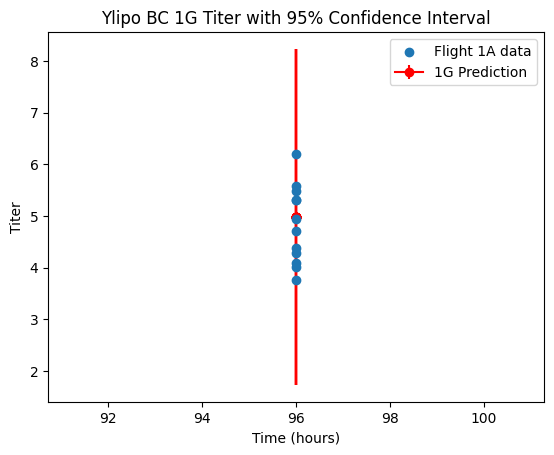

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


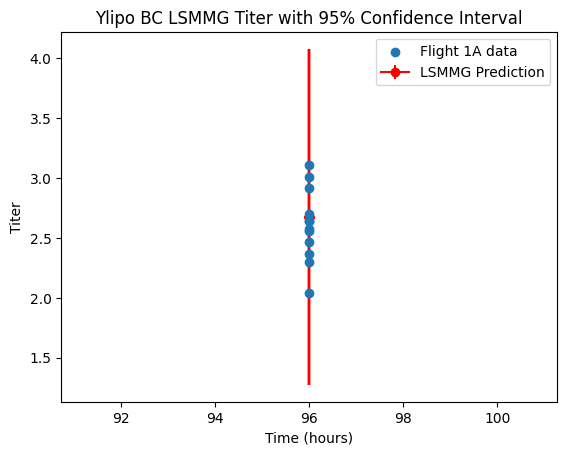

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


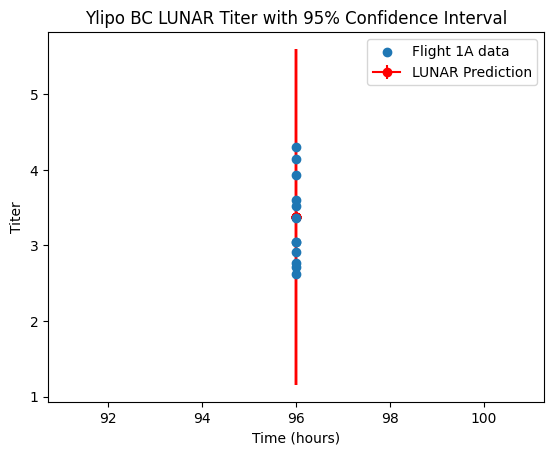

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


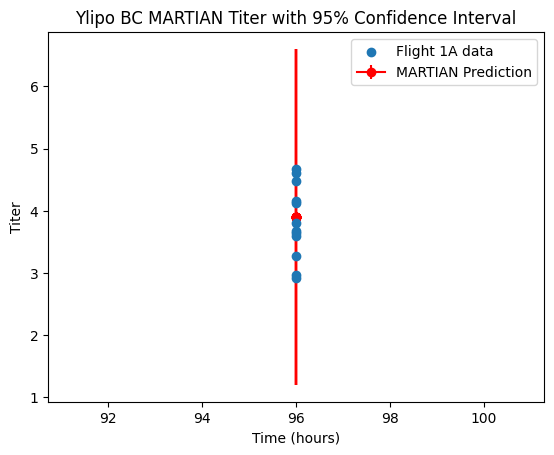

In [ ]:
for i, obj in enumerate(data_1A_list):

  predicted_output_mean, predicted_output_std = pnn.get_mean_and_standard_deviation(input_standardized_all_list[i])

  time_tensor = input_standardized_all_list[i][:, 3] * titer_time_input_std_dev + titer_time_input_mean

  predicted_output_mean = predicted_output_mean.flatten()
  predicted_output_std = predicted_output_std.flatten()

  plt.title(f"{organism_encode.inverse_transform([data_1A_list[i].organism])[0]} {substance_encode.inverse_transform([data_1A_list[i].substance])[0]} {gravity_encode.inverse_transform([data_1A_list[i].gravity])[0]} Titer with 95% Confidence Interval")

  plt.errorbar(time_tensor,
               np.exp(predicted_output_mean) - 0.1,
               np.exp(predicted_output_mean + 3 * predicted_output_std) - np.exp(predicted_output_mean),
               marker = 'o',
               color = 'red',
               label = f"{gravity_encode.inverse_transform([data_1A_list[i].gravity])[0]} Prediction",
               zorder = 1)

  plt.scatter(time_tensor,
              data_1A_list[i].titer_val_np,
              label = "Flight 1A data",
              zorder = 2)

  plt.xlabel("Time (hours)")
  plt.ylabel("Titer")
  plt.legend()
  plt.show()


#Flight 1B

In [ ]:
!rm *.xlsx
uploaded_1B = files.upload()

Saving Ecoli_BC_1G_1B.xlsx to Ecoli_BC_1G_1B.xlsx
Saving Ecoli_BC_LSMMG_1B.xlsx to Ecoli_BC_LSMMG_1B.xlsx
Saving Ppas_BC_1G_1B.xlsx to Ppas_BC_1G_1B.xlsx
Saving Ppas_BC_LSMMG_1B.xlsx to Ppas_BC_LSMMG_1B.xlsx
Saving Ppas_Wild_1G_1B.xlsx to Ppas_Wild_1G_1B.xlsx
Saving Ppas_Wild_LSMMG_1B.xlsx to Ppas_Wild_LSMMG_1B.xlsx
Saving Scere_BC_1G_1B.xlsx to Scere_BC_1G_1B.xlsx
Saving Scere_BC_LSMMG_1B.xlsx to Scere_BC_LSMMG_1B.xlsx
Saving Scere_Wild_1G_1B.xlsx to Scere_Wild_1G_1B.xlsx
Saving Scere_Wild_LSMMG_1B.xlsx to Scere_Wild_LSMMG_1B.xlsx
Saving Ylipo_BC_1G_1B.xlsx to Ylipo_BC_1G_1B.xlsx
Saving Ylipo_BC_LSMMG_1B.xlsx to Ylipo_BC_LSMMG_1B.xlsx
Saving Ylipo_Wild_1G_1B.xlsx to Ylipo_Wild_1G_1B.xlsx
Saving Ylipo_Wild_LSMMG_1B.xlsx to Ylipo_Wild_LSMMG_1B.xlsx


In [ ]:
organism_1B_list = []
substance_1B_list = []
gravity_1B_list = []
obj_1B_list = []

In [ ]:
class Preprocess_flight:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity, self.flight = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_1A_list, self.organism)
    self.update_list(substance_1A_list, self.substance)
    self.update_list(gravity_1A_list, self.gravity)

  def update_list(self, item_list, item):
    #if item not in item_list:
    item_list.append(item)

In [ ]:
for file_name in uploaded_1B.keys():
  obj = Preprocess_flight(file_name)
  obj_1B_list.append(obj)
  print(file_name)

Ecoli_BC_1G_1B.xlsx
Ecoli_BC_LSMMG_1B.xlsx
Ppas_BC_1G_1B.xlsx
Ppas_BC_LSMMG_1B.xlsx
Ppas_Wild_1G_1B.xlsx
Ppas_Wild_LSMMG_1B.xlsx
Scere_BC_1G_1B.xlsx
Scere_BC_LSMMG_1B.xlsx
Scere_Wild_1G_1B.xlsx
Scere_Wild_LSMMG_1B.xlsx
Ylipo_BC_1G_1B.xlsx
Ylipo_BC_LSMMG_1B.xlsx
Ylipo_Wild_1G_1B.xlsx
Ylipo_Wild_LSMMG_1B.xlsx


In [ ]:
def locate_label(var, var_list, var_encode_list):
  index = var_list.index(var)
  return var_encode_list[index]

In [ ]:
data_1B_list = []
input_standardized_all_list = []
input_standardized_all_tensor = None
output_all_tensor = None

for i, obj in enumerate(obj_1B_list):


    organism_locate_label = locate_label(obj.organism, organism_list, organism_label)
    substance_locate_label = locate_label(obj.substance, substance_list, substance_label)
    gravity_locate_label = locate_label(obj.gravity, gravity_list, gravity_label)

    #use the combination of labels to locate the correct obj_list item
    data_obj = Data(obj.file_name, organism_locate_label, substance_locate_label, gravity_locate_label)
    if substance_encode.inverse_transform([data_obj.substance])[0] != "Wild":
      data_1B_list.append(data_obj)

      #combine into categorical inputs
      categorical_inputs = [organism_locate_label, substance_locate_label, gravity_locate_label]
      categorical_inputs_transformed = torch.tensor([categorical_inputs]).squeeze()

      time_tensor = torch.tensor(data_obj.titer_input_np[:,3], dtype = torch.float32)
      categorical_inputs_transformed_stacked = torch.Tensor.repeat(categorical_inputs_transformed, len(time_tensor)).reshape(-1, len(categorical_inputs))

      input_unstandardized = torch.hstack((categorical_inputs_transformed_stacked, time_tensor.reshape(-1, 1)))
      input_unstandardized[:,3] = (input_unstandardized[:,3] - titer_time_input_mean) / titer_time_input_std_dev

      input_standardized = input_unstandardized
      input_standardized_all_list.append(input_standardized)
      if input_standardized_all_tensor is None:
        input_standardized_all_tensor = torch.tensor(input_standardized)
        output_all_tensor = torch.tensor(data_obj.titer_val_np)
      else:
        input_standardized_all_tensor = torch.vstack((input_standardized_all_tensor, input_standardized))
        output_all_tensor = torch.vstack((output_all_tensor, torch.tensor(data_obj.titer_val_np)))
output_all_tensor = torch.log(output_all_tensor + 0.1)

<ipython-input-235-4f05768d486c>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_standardized_all_tensor = torch.tensor(input_standardized)


In [ ]:
model_train = False
model_path_3 = '/content/drive/My Drive/Research/DARPA_B_SURE/2024/May Transfer Learning PNN Titer/May_PNN_transfer_learning_04-21_03-07-52.pth'

In [ ]:
if model_train:
  #80% train, 10% validation, 10% test
  input_train, input_test_val, output_train, output_test_val = train_test_split(input_standardized_all_tensor, output_all_tensor , test_size = 0.2, random_state = 42)
  input_val, input_test, output_val, output_test = train_test_split(input_test_val, output_test_val, test_size = 0.5, random_state = 42)

  train_data = DataLoader(TensorDataset(torch.tensor(input_train, dtype = torch.float32), torch.tensor(output_train, dtype = torch.float32)))
  test_data = DataLoader(TensorDataset(torch.tensor(input_test, dtype = torch.float32), torch.tensor(output_test, dtype = torch.float32)))
  val_data = DataLoader(TensorDataset(torch.tensor(input_val, dtype = torch.float32), torch.tensor(output_val, dtype = torch.float32)))


  """Train the model with a pytorch-lightning trainer."""
  trainer = pl.Trainer(max_epochs=100, check_val_every_n_epoch=50)
  trainer.fit(pnn, train_data, val_data)
  # Get the test output.
  test_results = trainer.test(pnn, test_data)

  timestamp = datetime.now()
  time_path = f"_{timestamp.strftime('%m-%d_%H-%M-%S')}.pth"
  torch.save(pnn.state_dict(), model_path_3 + time_path)

  files.download(model_path_3)
else:

  time_path = ".pth"
  pnn.load_state_dict(torch.load(model_path_3))

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


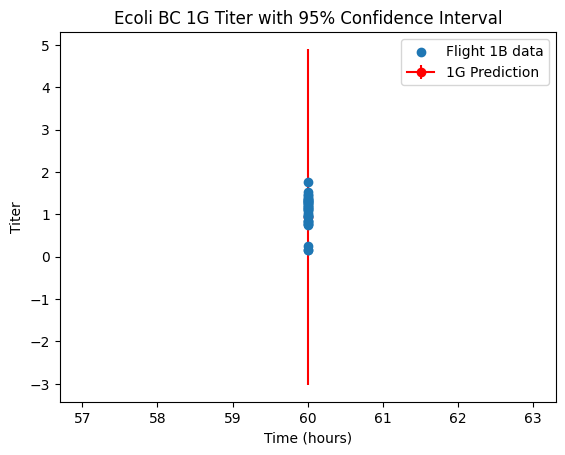

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


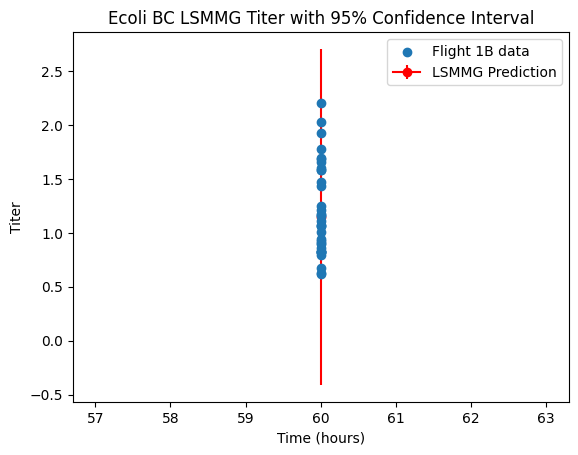

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


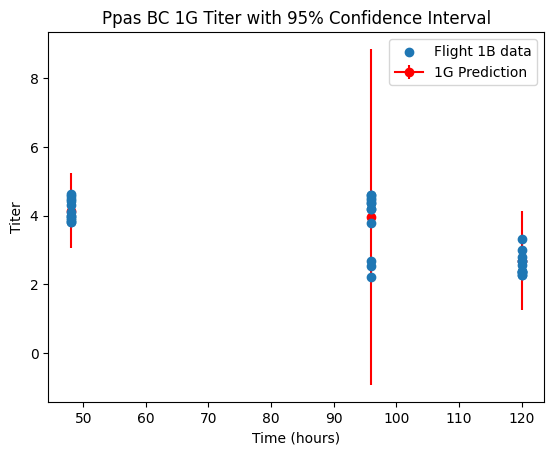

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


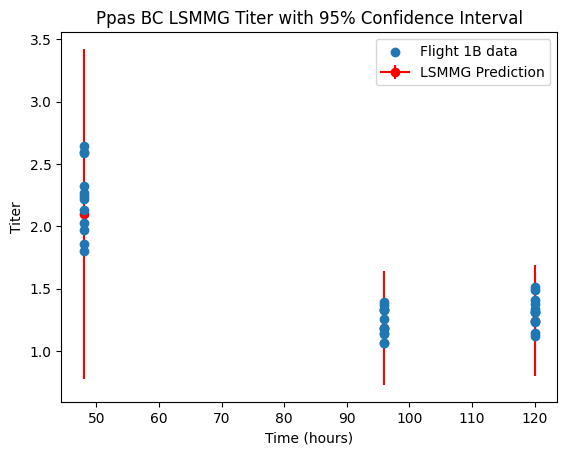

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


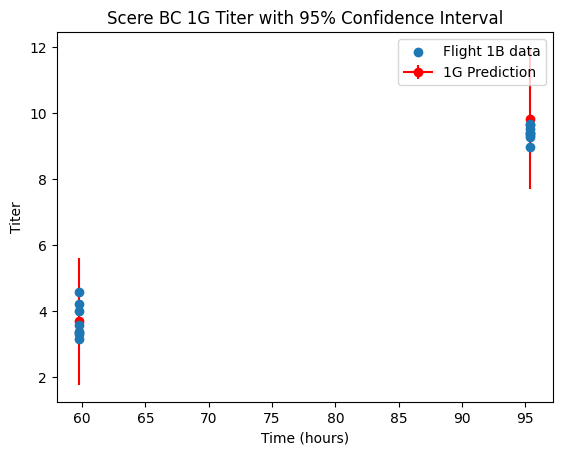

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


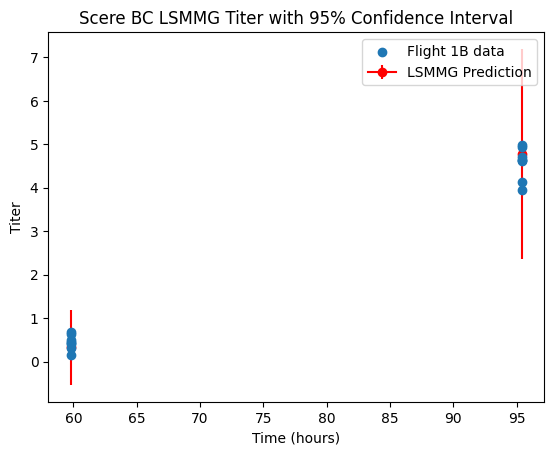

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


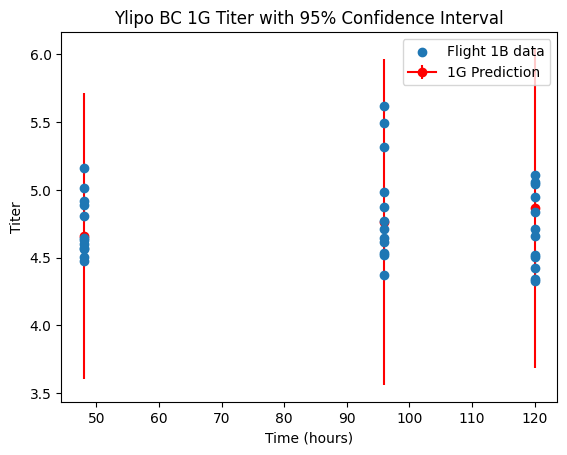

<ipython-input-4-7ea1985b1e64>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


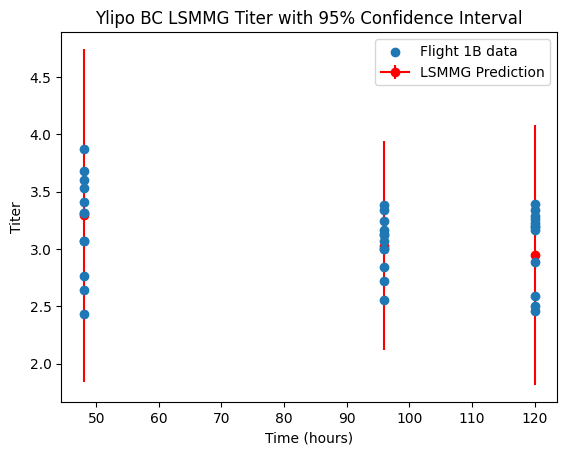

In [ ]:
for i, obj in enumerate(data_1B_list):

  predicted_output_mean, predicted_output_std = pnn.get_mean_and_standard_deviation(input_standardized_all_list[i])
  time_tensor = input_standardized_all_list[i][:, 3] * titer_time_input_std_dev + titer_time_input_mean
  predicted_output_mean = predicted_output_mean.flatten()
  predicted_output_std = predicted_output_std.flatten()
  plt.title(f"{organism_encode.inverse_transform([data_1B_list[i].organism])[0]} {substance_encode.inverse_transform([data_1B_list[i].substance])[0]} {gravity_encode.inverse_transform([data_1B_list[i].gravity])[0]} Titer with 95% Confidence Interval")
  unique_values, indexes = np.unique(time_tensor, return_index=True)

  for j, index in enumerate(indexes):

    plt.errorbar(time_tensor[index],
                 np.exp(predicted_output_mean[index]) - 0.1,
                 np.exp(predicted_output_mean[index] + 3 * predicted_output_std[index]) - np.exp(predicted_output_mean[index]),
                 color = 'red',
                 marker = 'o',
                 label=(f"{gravity_encode.inverse_transform([data_1B_list[i].gravity])[0]} Prediction" if j == 0 else ""),
                 zorder = 1,)

  plt.scatter(time_tensor,
              data_1B_list[i].titer_val_np,
              label = "Flight 1B data",
              zorder = 2)

  plt.xlabel("Time (hours)")
  plt.ylabel("Titer")
  plt.legend()
  plt.show()
